In [61]:
%reload_ext autoreload
%autoreload 2

In [62]:
import autorootcwd
import torch
import os
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data.dataloader import DataLoader
from sklearn.metrics import confusion_matrix

from src.utils import chord_to_id_map, id_to_chord_map, get_torch_device, collate_fn, get_annotation_metadata, get_chord_quality, get_chord_root
from src.models.ismir2017 import ISMIR2017ACR
from src.data.dataset import FullChordDataset

# Basics

### Get the model

In [65]:
experiment_name = 'first-large-vocab'

print(os.listdir(f'./data/experiments/{experiment_name}'))

device = get_torch_device()
state_dict = torch.load(f'./data/experiments/{experiment_name}/best_model.pth', weights_only=True)
model = ISMIR2017ACR(cr2=False)
model.load_state_dict(state_dict)
model.eval()

['metrics.json', 'metadata.json', 'best_model.pth', 'training_args.json', 'training_history.json']


ISMIR2017ACR(
  (batch_norm): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (conv2): Conv2d(1, 36, kernel_size=(1, 216), stride=(1, 1))
  (bi_gru_encoder): GRU(36, 256, batch_first=True, bidirectional=True)
  (dense): Linear(in_features=512, out_features=170, bias=True)
)

### Run the Model

In [66]:
dataset = FullChordDataset()

dataset[0][0].shape

torch.Size([2323, 216])

In [106]:
all_preds = []
all_labels = []

with torch.no_grad():  # Use no_grad to speed up inference
    for i in tqdm(range(len(dataset))):
        cqt, label = dataset[i]
        pred = model(cqt.unsqueeze(0))
        preds = torch.argmax(pred, dim=2)
        all_preds.append(preds[0])  # Keep as tensors
        all_labels.append(label)    # Keep as tensors

# Concatenate all predictions and labels at the end
all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

100%|██████████| 1213/1213 [04:58<00:00,  4.07it/s]


### Overall Accuracy

In [107]:
# Overall accuracy
from sklearn.metrics import accuracy_score
accuracy_score(all_labels, all_preds)

0.6432940301999254

### Confusion Matrices

In [78]:
# Map chord IDs to chord qualities
all_labels_quality = [get_chord_quality(id) for id in all_labels]
all_preds_quality = [get_chord_quality(id) for id in all_preds]

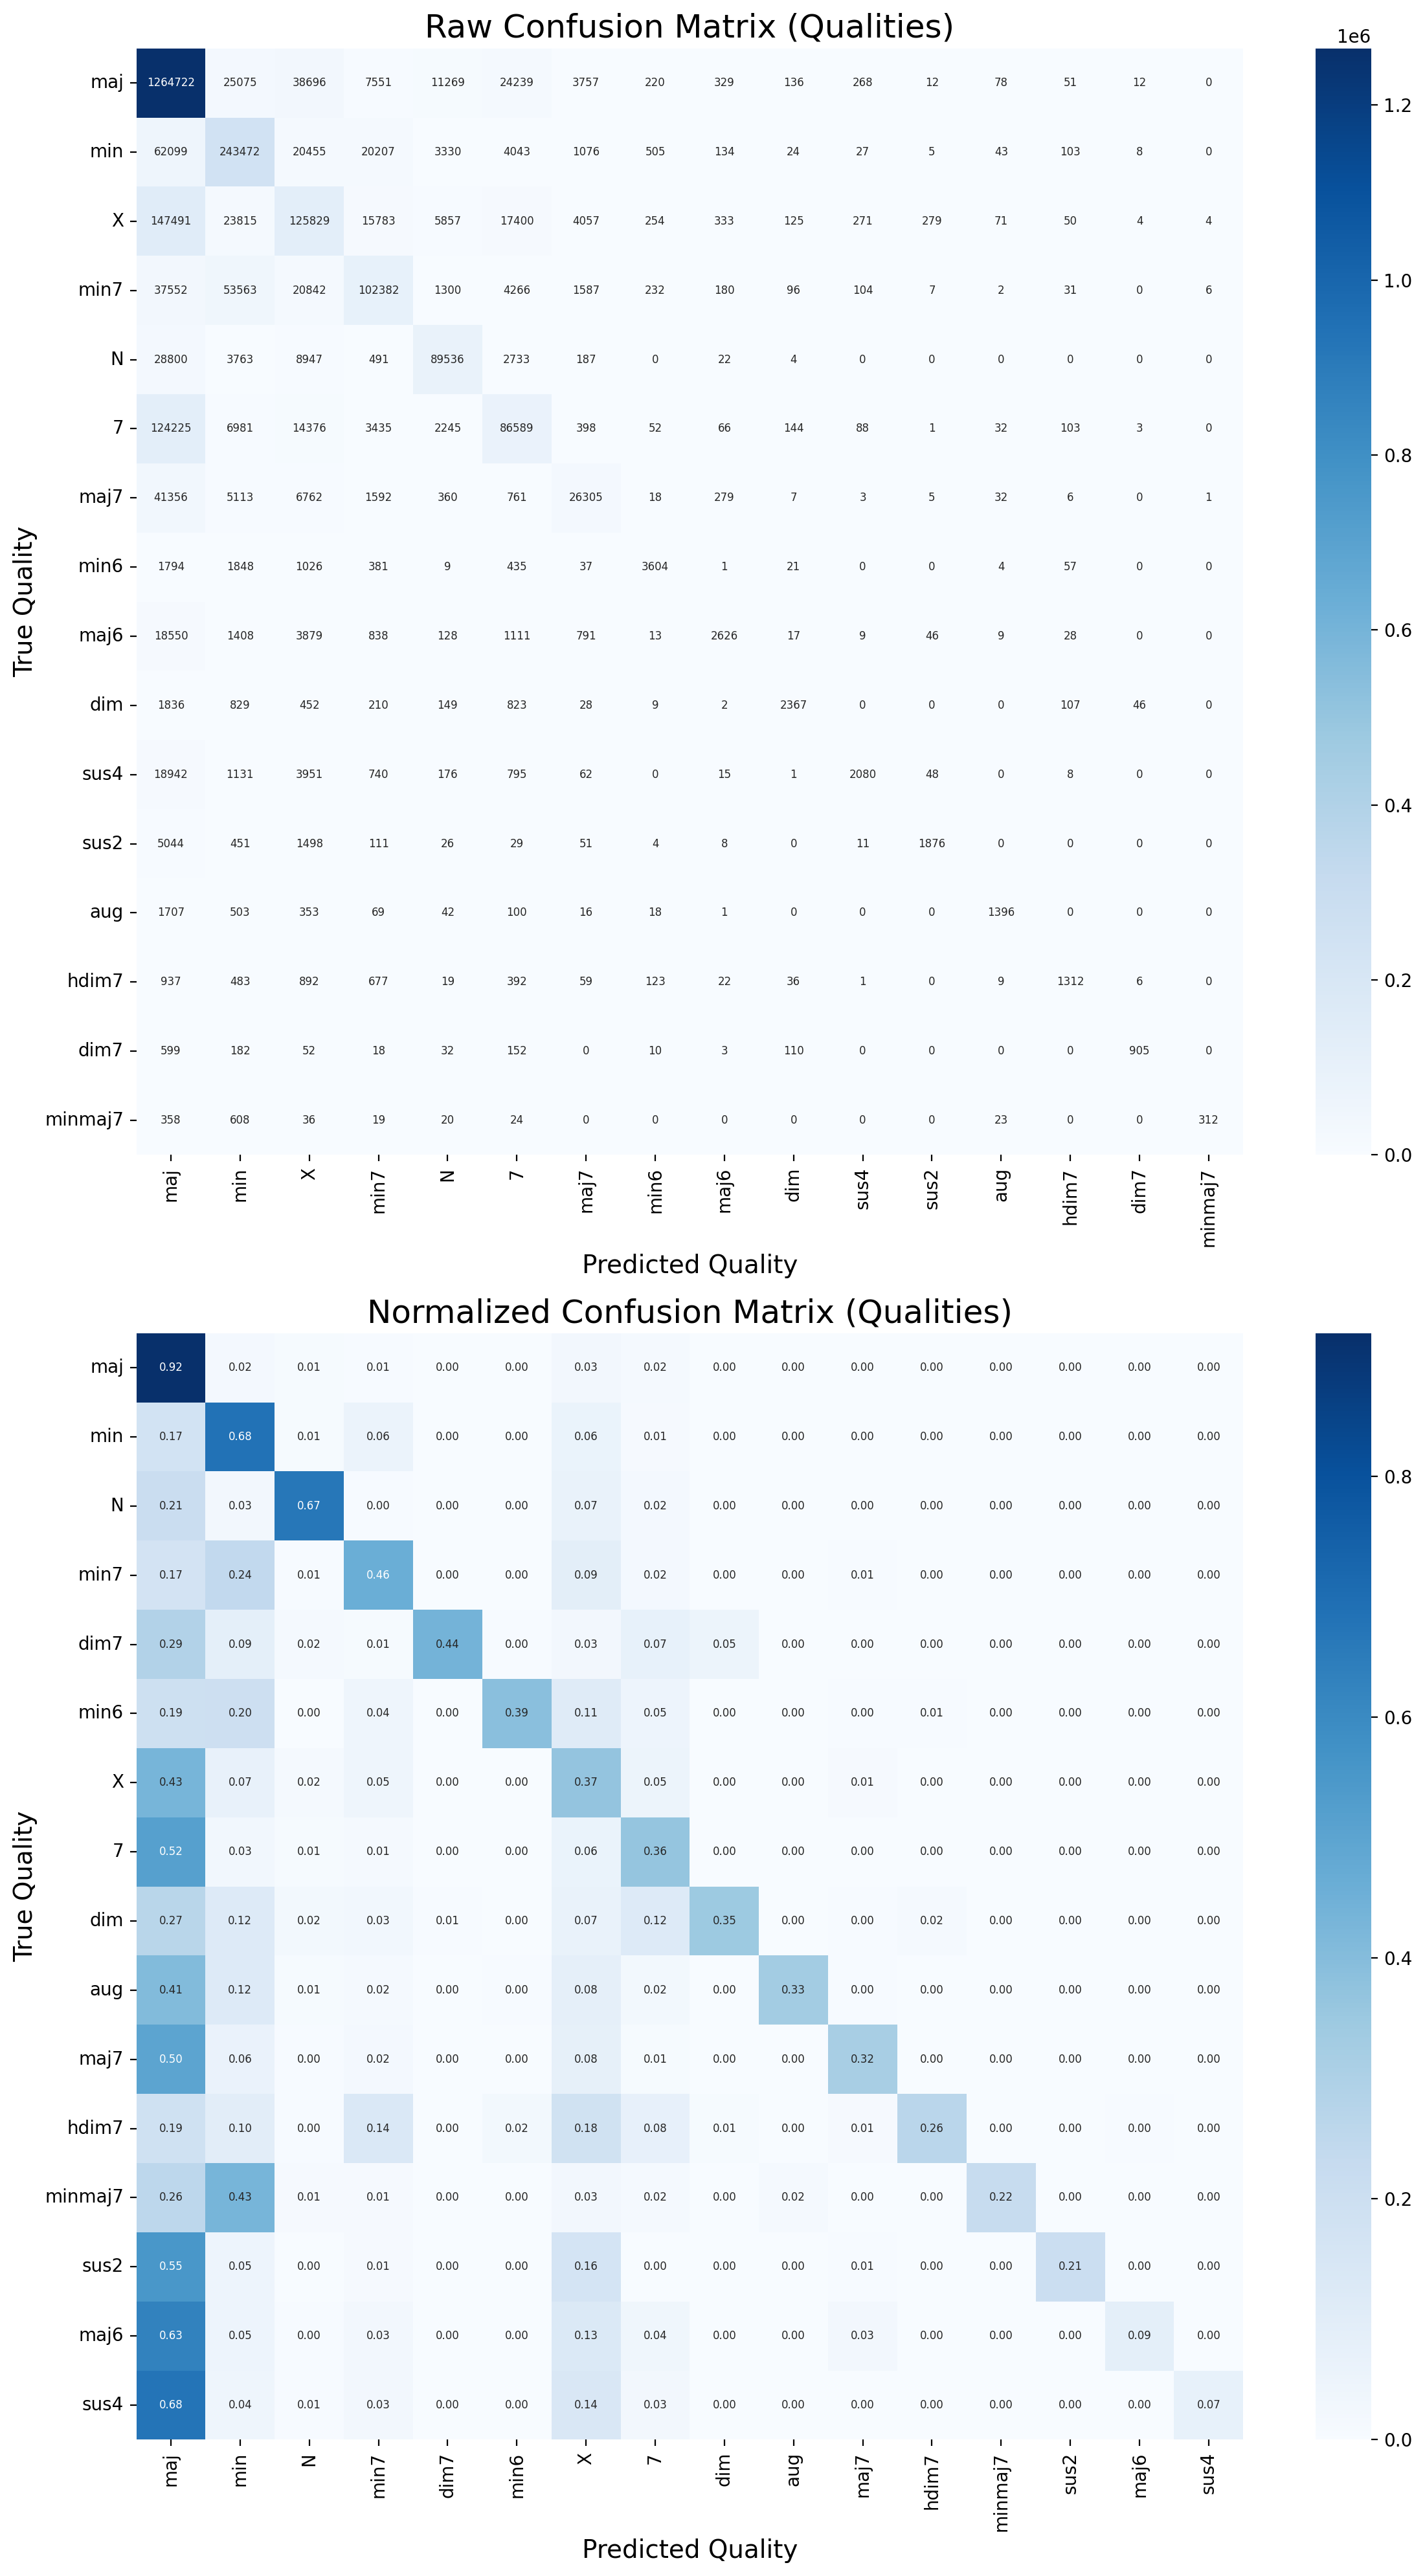

In [80]:
# Get unique qualities and map them to indices
unique_qualities = sorted(set(all_labels_quality + all_preds_quality))
quality_to_id = {quality: i for i, quality in enumerate(unique_qualities)}
id_to_quality = {i: quality for i, quality in enumerate(unique_qualities)}

# Convert qualities to indices for confusion matrix computation
labels_quality_idx = [quality_to_id[quality] for quality in all_labels_quality]
preds_quality_idx = [quality_to_id[quality] for quality in all_preds_quality]

# Compute confusion matrix and normalized confusion matrix
cm_quality = confusion_matrix(labels_quality_idx, preds_quality_idx, labels=range(len(unique_qualities)))
cm_quality_normalized = cm_quality.astype('float') / cm_quality.sum(axis=1, keepdims=True)

# Reorder both confusion matrices in descending order of diagonal values
order_quality = np.argsort(-np.diag(cm_quality))  # Raw matrix order
order_quality_normalized = np.argsort(-np.diag(cm_quality_normalized))  # Normalized matrix order

# Reorder the confusion matrices
cm_quality_reordered = cm_quality[order_quality][:, order_quality]
cm_quality_normalized_reordered = cm_quality_normalized[order_quality_normalized][:, order_quality_normalized]

# Map reordered indices back to chord qualities
quality_labels_reordered = [id_to_quality[id] for id in order_quality]
quality_labels_normalized_reordered = [id_to_quality[id] for id in order_quality_normalized]

# Plot the confusion matrices
fig, axes = plt.subplots(2, 1, figsize=(12, 20))

# Raw confusion matrix (qualities)
sns.heatmap(cm_quality_reordered, annot=True, fmt='d', cmap='Blues', 
            xticklabels=quality_labels_reordered, yticklabels=quality_labels_reordered, 
            ax=axes[0], cbar=True, annot_kws={"fontsize": 6}, square=True)
axes[0].set_title("Raw Confusion Matrix (Qualities)", fontsize=18)
axes[0].set_xlabel('Predicted Quality', fontsize=14)
axes[0].set_ylabel('True Quality', fontsize=14)

# Normalized confusion matrix (qualities)
sns.heatmap(cm_quality_normalized_reordered, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=quality_labels_normalized_reordered, yticklabels=quality_labels_normalized_reordered, 
            ax=axes[1], cbar=True, annot_kws={"fontsize": 6}, square=True)
axes[1].set_title("Normalized Confusion Matrix (Qualities)", fontsize=18)
axes[1].set_xlabel('Predicted Quality', fontsize=14)
axes[1].set_ylabel('True Quality', fontsize=14)

plt.tight_layout()
plt.show()

In [109]:
#  Map chord IDs to chord roots
all_labels_root = [get_chord_root(id) for id in all_labels]
all_preds_root = [get_chord_root(id) for id in all_preds]

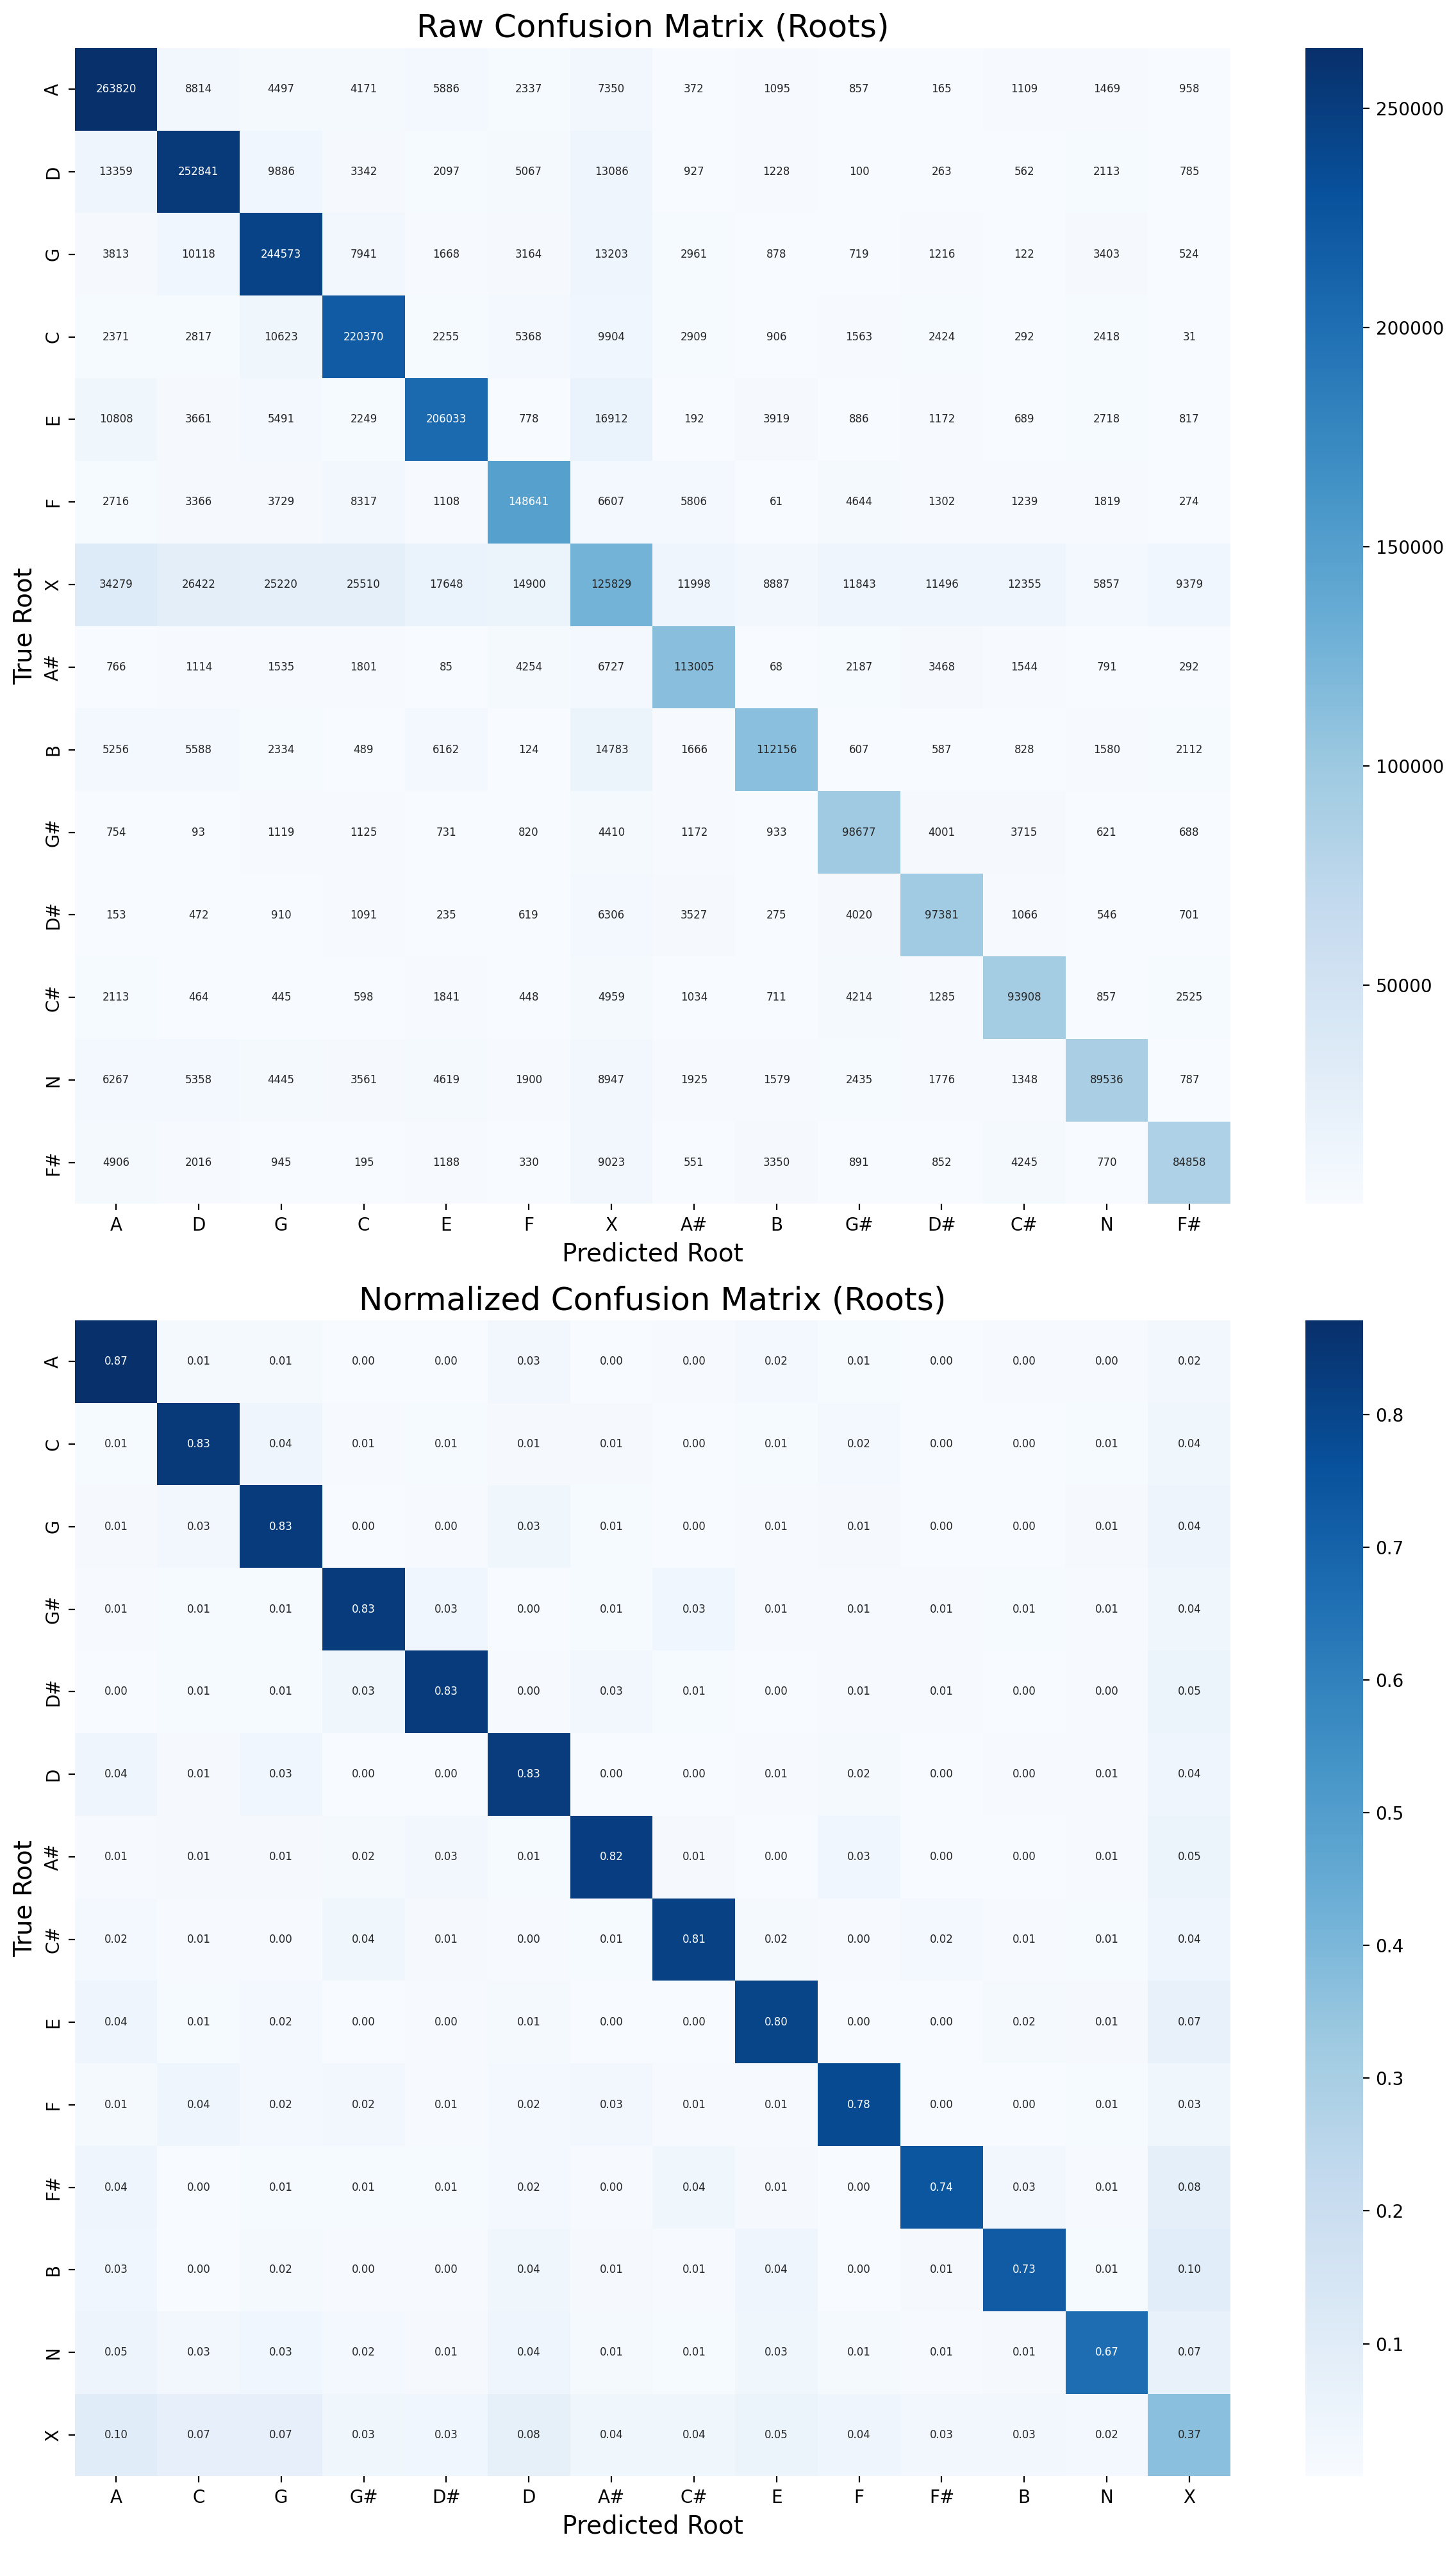

In [113]:
# Get unique roots and map them to indices
unique_roots = sorted(set(all_labels_root + all_preds_root))
root_to_id = {root: i for i, root in enumerate(unique_roots)}
id_to_root = {i: root for i, root in enumerate(unique_roots)}

# Convert roots to indices for confusion matrix computation
labels_root_idx = [root_to_id[root] for root in all_labels_root]
preds_root_idx = [root_to_id[root] for root in all_preds_root]

# Compute confusion matrix and normalized confusion matrix
cm_root = confusion_matrix(labels_root_idx, preds_root_idx, labels=range(len(unique_roots)))
cm_root_normalized = cm_root.astype('float') / cm_root.sum(axis=1, keepdims=True)

# Reorder both confusion matrices in descending order of diagonal values
order_root = np.argsort(-np.diag(cm_root))  # Raw matrix order
order_root_normalized = np.argsort(-np.diag(cm_root_normalized))  # Normalized matrix order

# Reorder the confusion matrices
cm_root_reordered = cm_root[order_root][:, order_root]
cm_root_normalized_reordered = cm_root_normalized[order_root_normalized][:, order_root_normalized]

# Map reordered indices back to chord roots
root_labels_reordered = [id_to_root[id] for id in order_root]
root_labels_normalized_reordered = [id_to_root[id] for id in order_root_normalized]

# Plot the confusion matrices
fig, axes = plt.subplots(2, 1, figsize=(12, 20))

# Raw confusion matrix (roots)
sns.heatmap(cm_root_reordered, annot=True, fmt='d', cmap='Blues', 
            xticklabels=root_labels_reordered, yticklabels=root_labels_reordered, 
            ax=axes[0], cbar=True, annot_kws={"fontsize": 6}, square=True)
axes[0].set_title("Raw Confusion Matrix (Roots)", fontsize=18)
axes[0].set_xlabel('Predicted Root', fontsize=14)
axes[0].set_ylabel('True Root', fontsize=14)

# Normalized confusion matrix (roots)
sns.heatmap(cm_root_normalized_reordered, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=root_labels_normalized_reordered, yticklabels=root_labels_normalized_reordered, 
            ax=axes[1], cbar=True, annot_kws={"fontsize": 6}, square=True)
axes[1].set_title("Normalized Confusion Matrix (Roots)", fontsize=18)
axes[1].set_xlabel('Predicted Root', fontsize=14)
axes[1].set_ylabel('True Root', fontsize=14)

plt.tight_layout()
plt.show()

# Incorrect Regions, Accuracy over Songs, Accuracy over time

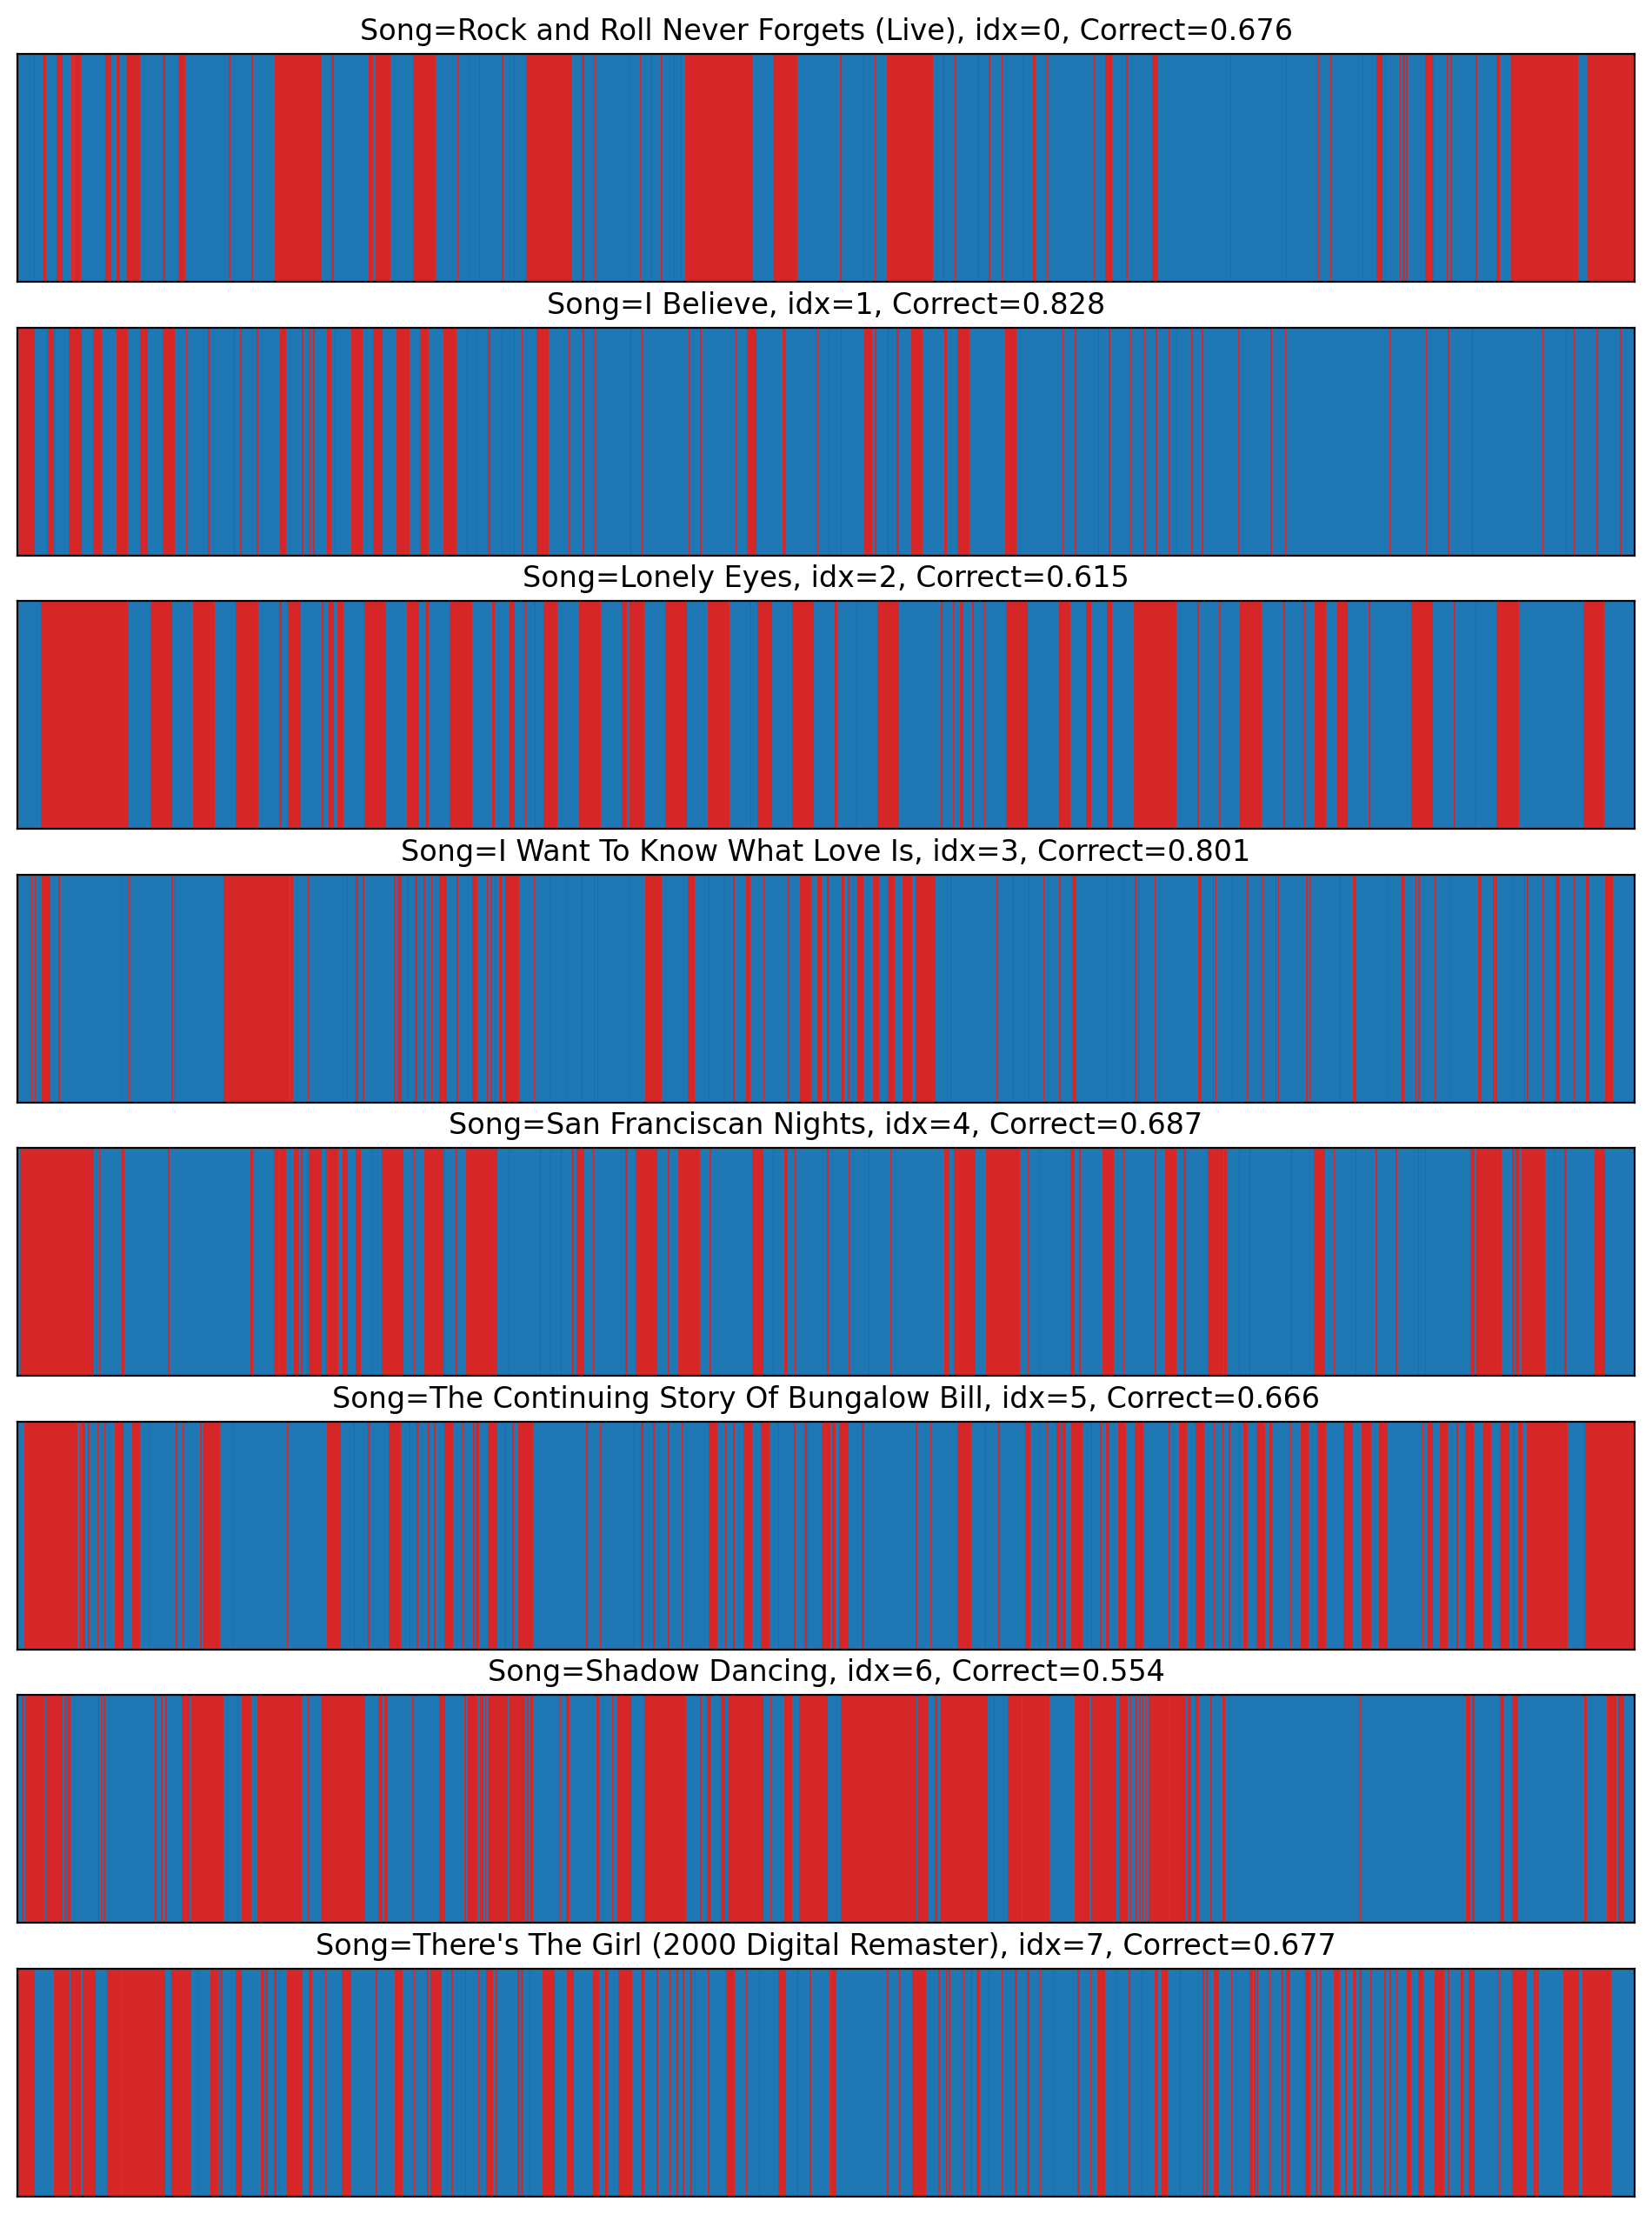

In [8]:
import matplotlib as mpl

cmap = mpl.colors.ListedColormap(["tab:red", "tab:blue"])
bounds = [0, 0.5, 1]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

example_indices = [0, 1, 2,3,4,5,6,7]  # choose whichever you like

fig, axes = plt.subplots(nrows=len(example_indices), figsize=(12, 2 * len(example_indices)))
for ax, idx in zip(axes, example_indices):
    cqt, label = dataset[idx]
    with torch.no_grad():
        pred = model(cqt.unsqueeze(0))
        pred_classes = torch.argmax(pred, dim=2).squeeze(0)
    
    correctness = (pred_classes == label).long().numpy()
    correctness_2d = correctness[np.newaxis, :]

    ax.imshow(correctness_2d, cmap=cmap, norm=norm, aspect="auto")
    title = get_annotation_metadata(dataset.get_filename(idx))["title"]
    ax.set_title(f"Song={title}, idx={idx}, Correct={round(correctness.sum()/len(correctness),3)}", fontsize=12)
    ax.set_yticks([])
    ax.set_xticks([]) 

plt.show()

In [9]:
from itertools import groupby

# For accuracy histogram
all_accuracies = []

# For incorrect region analysis
incorrect_region_lengths = []
incorrect_frame_with_correct_neighbors = 0
total_incorrect_frames = 0
single_frame_regions = 0

# For average accuracy over time
max_length = max([len(dataset[idx][1]) for idx in range(len(dataset))])  # Longest song length
correctness_matrix = np.zeros((len(dataset), max_length))  # Rows: Songs, Columns: Time steps
valid_frames = np.zeros(max_length)  # To count valid entries at each time step

# Unified loop
for idx in tqdm(range(len(dataset))):
    cqt, label = dataset[idx]
    with torch.no_grad():
        pred = model(cqt.unsqueeze(0))
        pred_classes = torch.argmax(pred, dim=2).squeeze(0)
    
    correctness = (pred_classes == label).long().numpy()
    incorrect_mask = correctness == 0

    # Accuracy for the histogram
    accuracy = correctness.sum() / len(correctness)
    all_accuracies.append(accuracy)

    # Incorrect region analysis
    region_lengths = [len(list(group)) for val, group in groupby(incorrect_mask) if val]
    incorrect_region_lengths.extend(region_lengths)
    single_frame_regions += region_lengths.count(1)
    total_incorrect_frames += np.sum(incorrect_mask)
    for i in range(1, len(correctness) - 1):
        if not correctness[i] and correctness[i - 1] and correctness[i + 1]:
            incorrect_frame_with_correct_neighbors += 1

    # Average accuracy over time
    correctness_matrix[idx, :len(correctness)] = correctness
    valid_frames[:len(correctness)] += 1

100%|██████████| 1213/1213 [04:56<00:00,  4.09it/s]


In [26]:
import pandas as pd
all_accuracies_series = pd.Series(all_accuracies)
all_accuracies_series.median()

0.6751030017657446

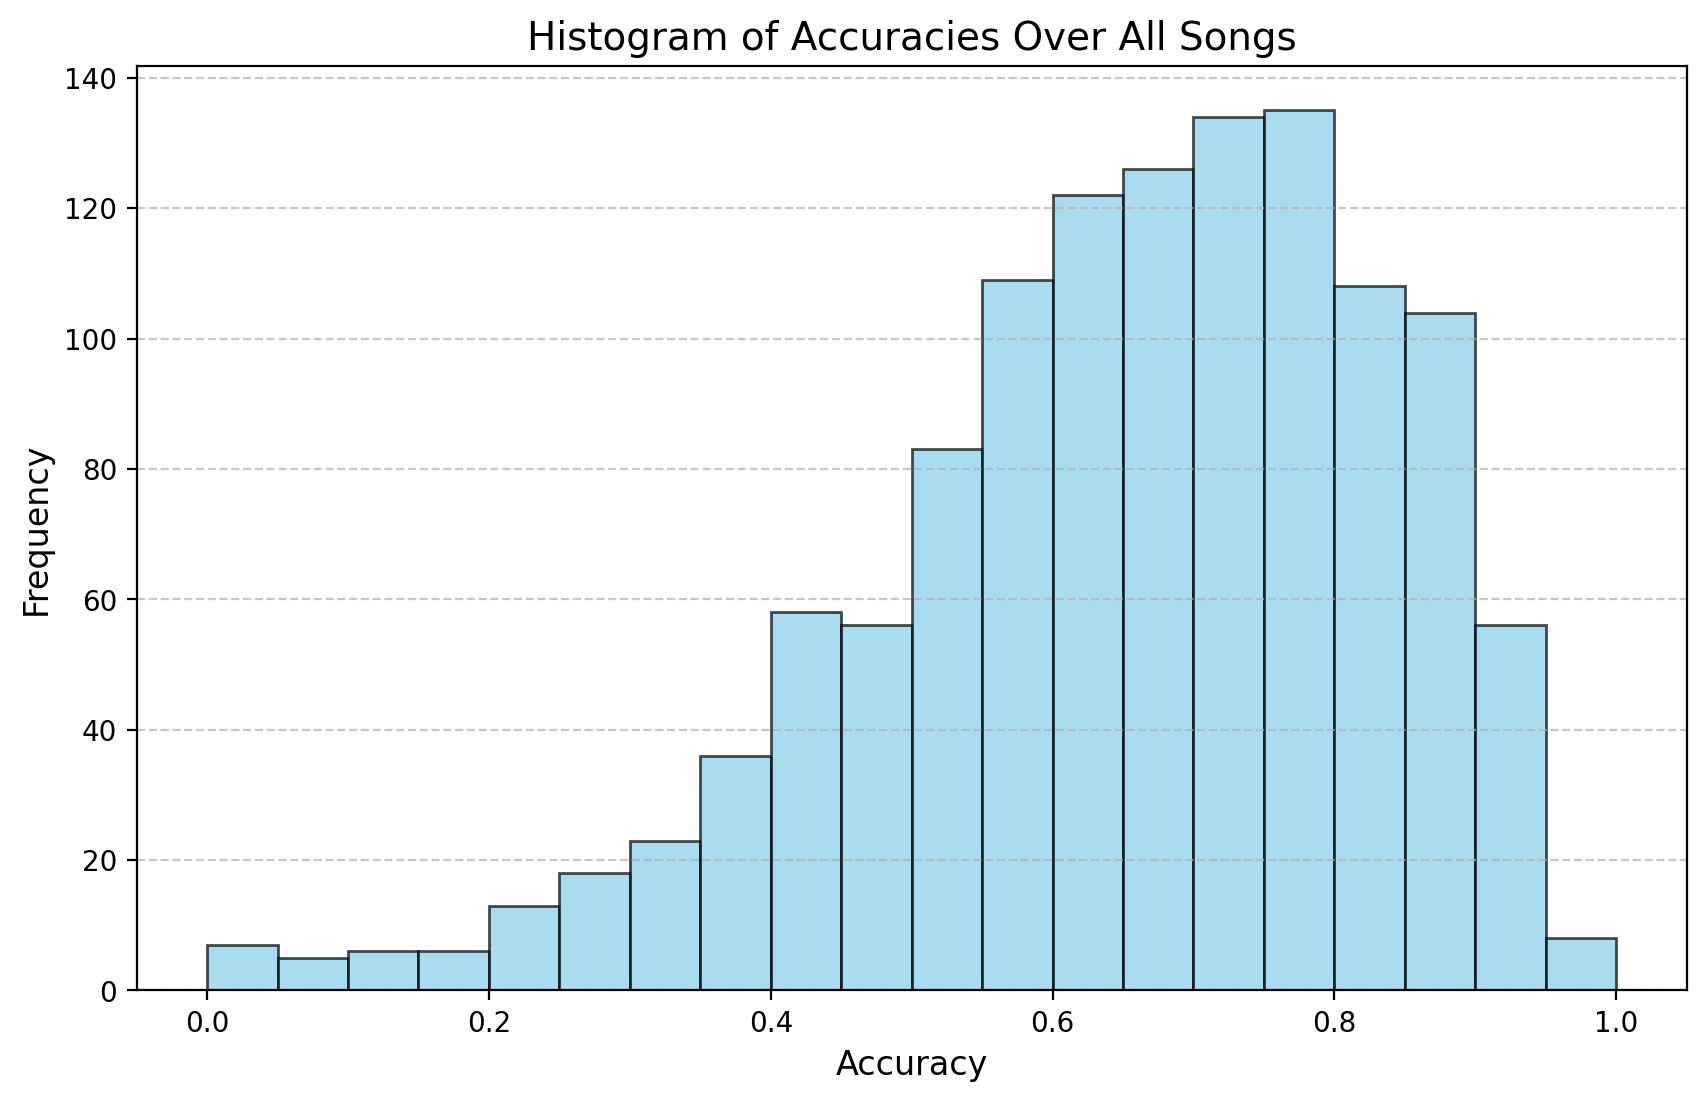

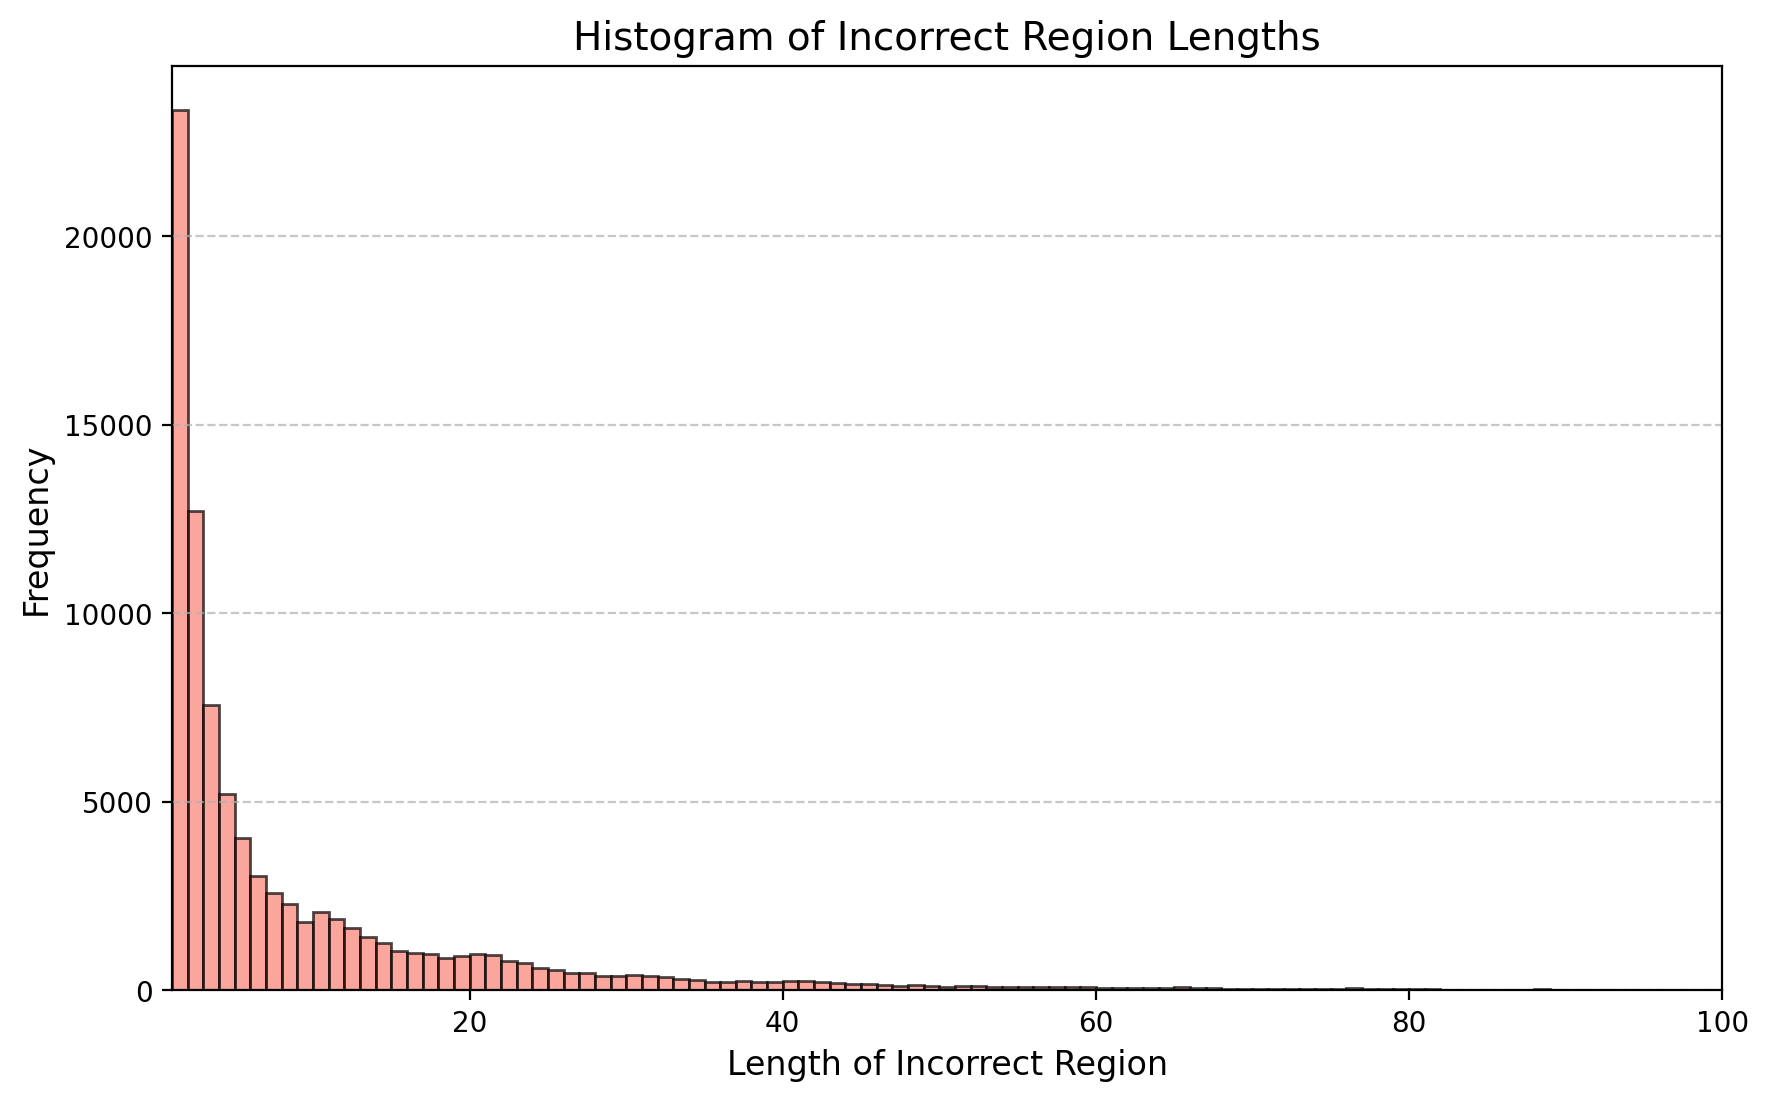

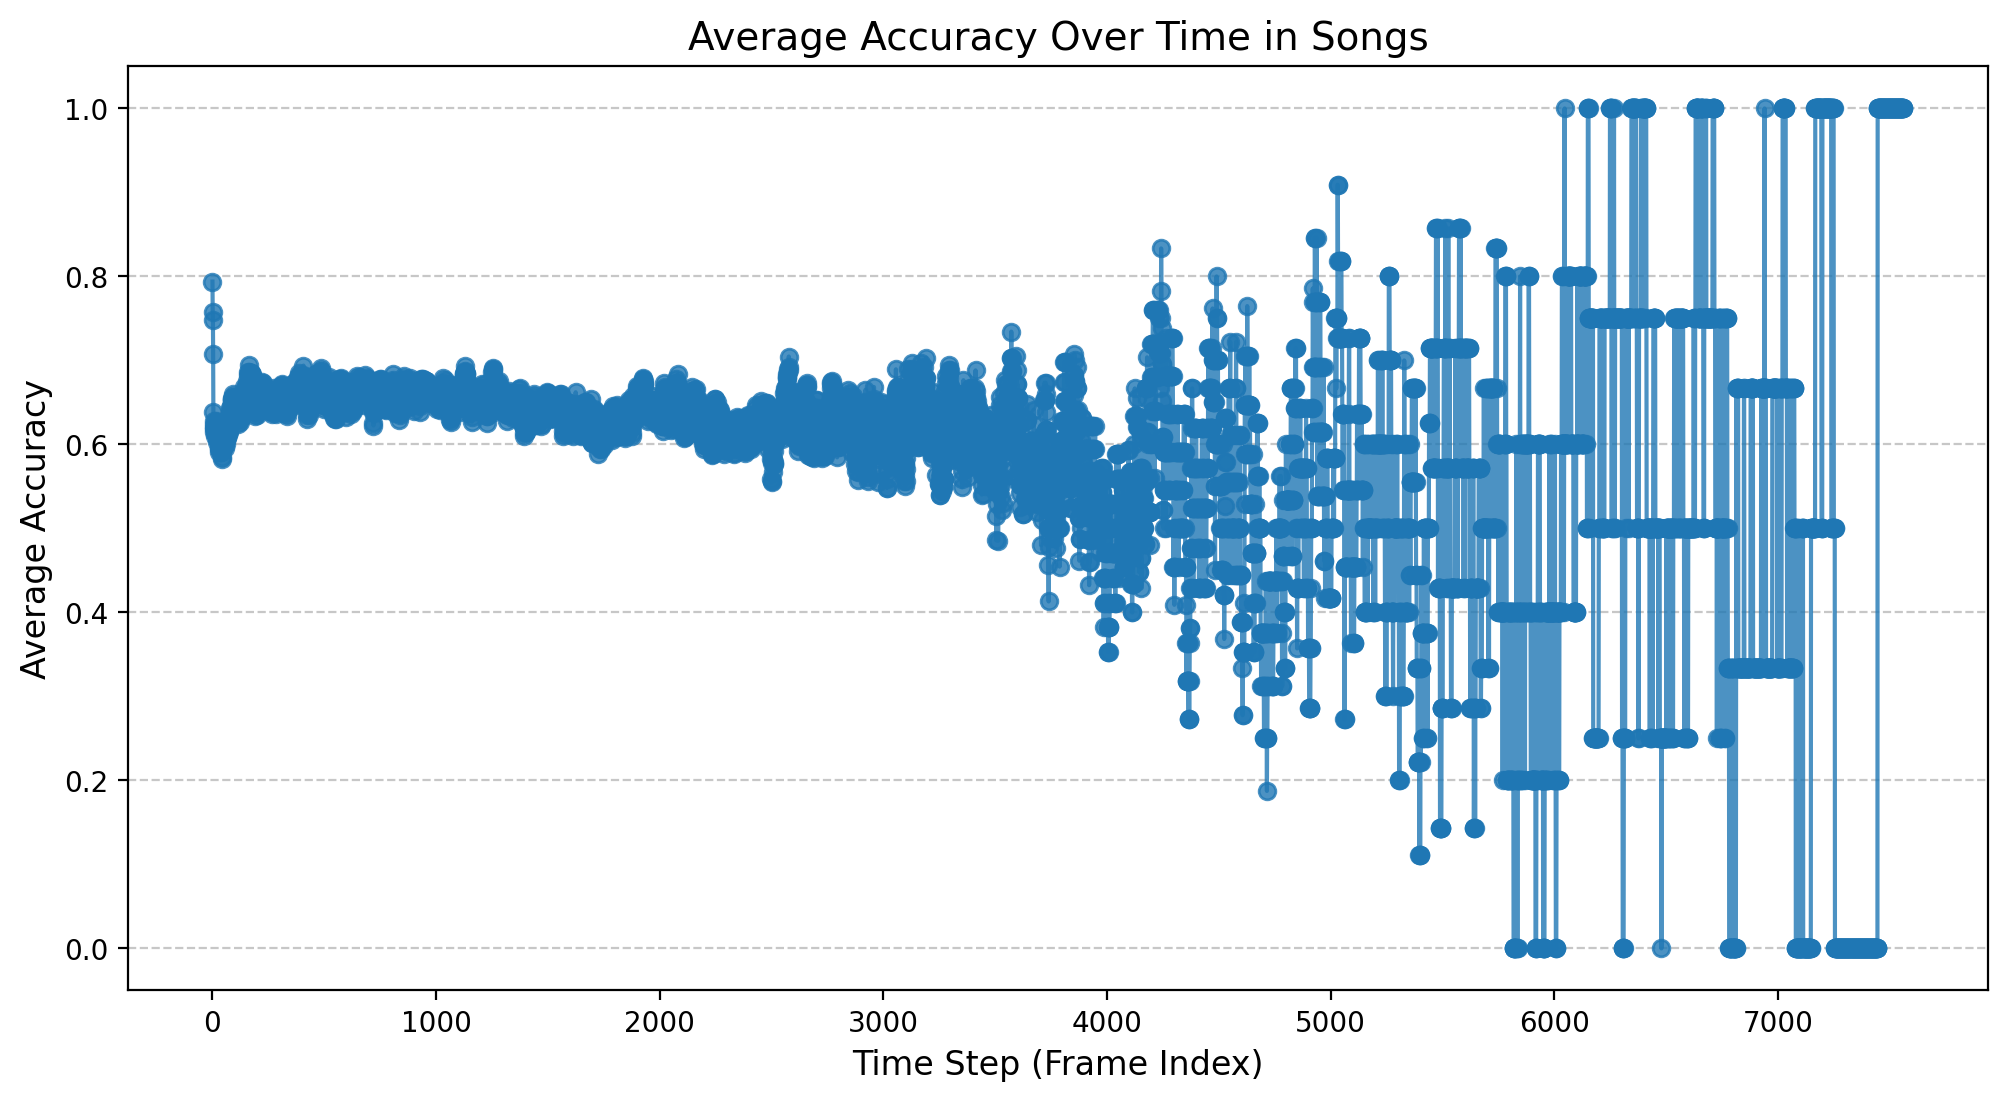

Percentage of incorrect regions that are 1 frame wide: 25.95%
Percentage of incorrect frames with correct neighbors on both sides: 2.29%


In [82]:
# Final computations and plots
percent_single_frame_regions = (single_frame_regions / len(incorrect_region_lengths)) * 100 if incorrect_region_lengths else 0
percent_incorrect_with_correct_neighbors = (incorrect_frame_with_correct_neighbors / total_incorrect_frames) * 100 if total_incorrect_frames else 0
average_accuracy_over_time = correctness_matrix.sum(axis=0) / valid_frames

# Accuracy histogram
plt.figure(figsize=(10, 6))
plt.hist(all_accuracies, bins=20, range=(0, 1), alpha=0.7, color='skyblue', edgecolor='black')
plt.title("Histogram of Accuracies Over All Songs", fontsize=14)
plt.xlabel("Accuracy", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Incorrect region histogram
plt.figure(figsize=(10, 6))
plt.hist(incorrect_region_lengths, bins=range(1, max(incorrect_region_lengths) + 2), alpha=0.7, color='salmon', edgecolor='black')
plt.xlim(1, 100)
plt.title("Histogram of Incorrect Region Lengths", fontsize=14)
plt.xlabel("Length of Incorrect Region", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Average accuracy over time plot
plt.figure(figsize=(12, 6))
plt.plot(average_accuracy_over_time, marker='o', linestyle='-', alpha=0.8)
plt.title("Average Accuracy Over Time in Songs", fontsize=14)
plt.xlabel("Time Step (Frame Index)", fontsize=12)
plt.ylabel("Average Accuracy", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Print percentages
print(f"Percentage of incorrect regions that are 1 frame wide: {percent_single_frame_regions:.2f}%")
print(f"Percentage of incorrect frames with correct neighbors on both sides: {percent_incorrect_with_correct_neighbors:.2f}%")

# Transition Frame Accuracy

In [11]:
from src.utils import get_chord_annotation

all_transitions = []
dataset = FullChordDataset()

for i in tqdm(range(len(dataset))):
    filename = dataset.get_filename(i)
    _, transitions = get_chord_annotation(filename, return_transitions=True, frame_length=dataset.hop_length / dataset.sr)
    _, labels = dataset[i]
    all_transitions.extend(transitions[:labels.shape[0]].tolist())

all_transitions = np.array(all_transitions)

100%|██████████| 1213/1213 [00:32<00:00, 37.85it/s]


In [12]:
# Compute overall accuracy
overall_acc = accuracy_score(all_labels, all_preds)

# Identify which indices are transitions vs non-transitions
transition_indices = [i for i, t in enumerate(all_transitions) if t]
non_transition_indices = [i for i, t in enumerate(all_transitions) if not t]

labels_transition = [all_labels[i] for i in transition_indices]
preds_transition  = [all_preds[i] for i in transition_indices]
labels_non_transition = [all_labels[i] for i in non_transition_indices]
preds_non_transition  = [all_preds[i] for i in non_transition_indices]

transition_acc = accuracy_score(labels_transition, preds_transition)
non_transition_acc = accuracy_score(labels_non_transition, preds_non_transition)

print("Overall Accuracy:", overall_acc)
print("Transition Frames Accuracy:", transition_acc)
print("Non-Transition Frames Accuracy:", non_transition_acc)

Overall Accuracy: 0.6432940301999254
Transition Frames Accuracy: 0.40143768517830763
Non-Transition Frames Accuracy: 0.65404581384982


In [14]:
# Percentage of frames that are transitions
num_transitions = sum(all_transitions)
print("Fraction of frames that are transitions:", round(num_transitions / len(all_transitions), 3))

Fraction of frames that are transitions: 0.043


# Context Lengths

### Different Context Lengths

Context length: 5


100%|██████████| 1697/1697 [04:10<00:00,  6.79it/s]


Context length: 10


100%|██████████| 850/850 [03:26<00:00,  4.11it/s]


Context length: 20


100%|██████████| 433/433 [02:52<00:00,  2.51it/s]


Context length: 60


100%|██████████| 157/157 [03:15<00:00,  1.24s/it]


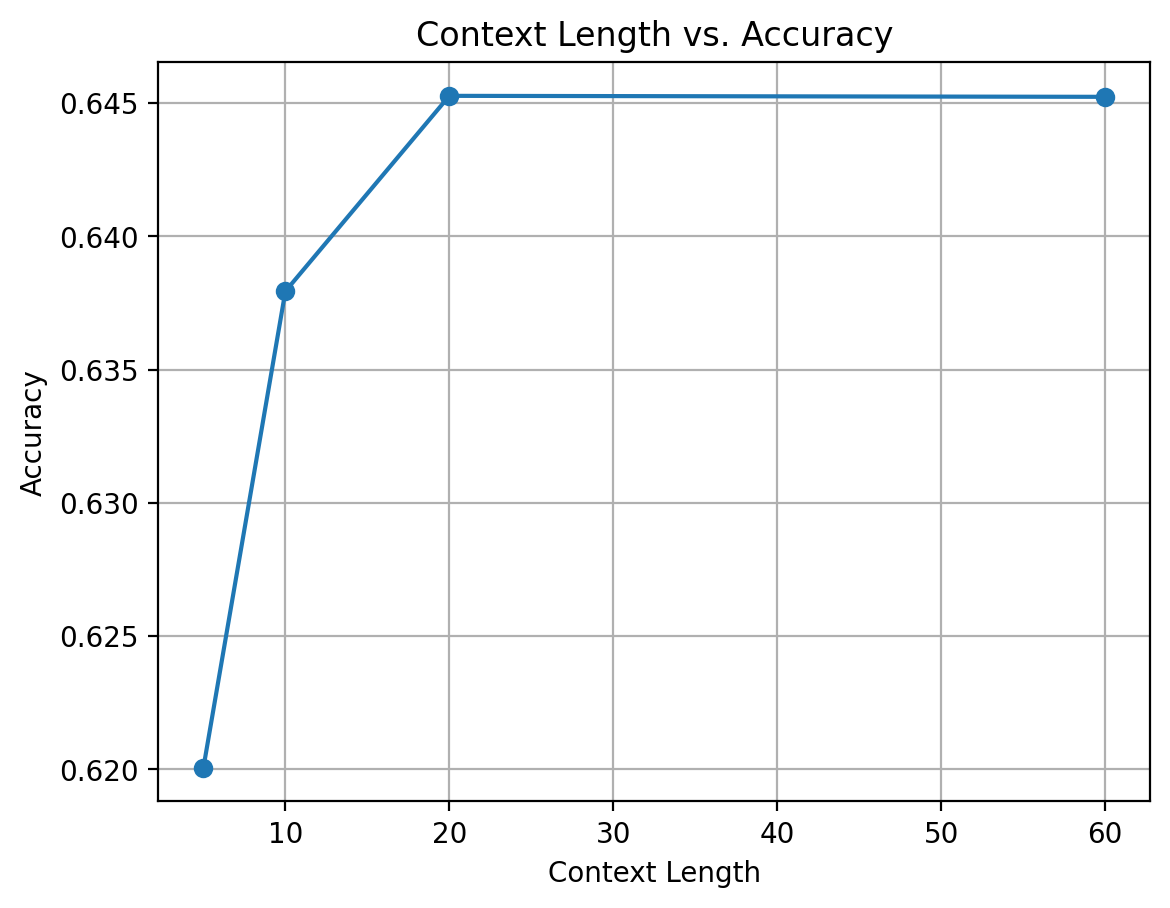

In [16]:
from src.data.dataset import FixedLengthChordDataset
from sklearn.metrics import accuracy_score

context_lengths = [5, 10, 20, 60]
accuracies = []
device = get_torch_device()
model.eval()
model.to(device)

for context_length in context_lengths:
    print(f"Context length: {context_length}")
    dataset = FixedLengthChordDataset(segment_length=context_length, cached=True)
    loader = DataLoader(dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
    all_preds_context = []
    all_labels_context = []
    for batch_cqt, batch_labels in tqdm(loader):
        batch_cqt, batch_labels = batch_cqt.to(device), batch_labels.to(device)
        batch_preds = model(batch_cqt)
        batch_preds = torch.argmax(batch_preds, dim=2).cpu()
        all_preds_context.extend(torch.flatten(batch_preds).tolist())
        all_labels_context.extend(torch.flatten(batch_labels).tolist())

    ignore_index = -1
    mask = torch.tensor(all_labels_context) != ignore_index
    all_preds_context = torch.tensor(all_preds_context)[mask]
    all_labels_context = torch.tensor(all_labels_context)[mask]
    accuracy = accuracy_score(all_labels_context, all_preds_context)
    accuracies.append(accuracy)

plt.plot(context_lengths, accuracies, marker='o')
plt.xlabel('Context Length')
plt.ylabel('Accuracy')
plt.title('Context Length vs. Accuracy')
plt.grid()
plt.show()

### Accuracy at Edeges of Context

In [17]:
from src.data.dataset import FixedLengthChordDataset
from torch.utils.data.dataloader import DataLoader
from sklearn.metrics import accuracy_score
from src.utils import collate_fn

accuracies = []
device = get_torch_device()
model.eval()
model.to(device)

dataset = FixedLengthChordDataset(segment_length=10, cached=True)
loader = DataLoader(dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
num_frames = dataset.segment_length_samples
frame_correct_counts = torch.zeros(num_frames)
frame_total_counts = torch.zeros(num_frames)

for batch_cqt, batch_labels in tqdm(loader):
    batch_cqt, batch_labels = batch_cqt.to(device), batch_labels.to(device)
    batch_preds = model(batch_cqt)
    batch_preds = torch.argmax(batch_preds, dim=2)
    correct = (batch_preds == batch_labels).cpu()
    # Mask out invalid labels (-1)
    valid_mask = batch_labels != -1  # Shape: (batch_size, num_frames)

    # Compute correctness only for valid frames
    correct = (batch_preds == batch_labels) & valid_mask  # Shape: (batch_size, num_frames)

    # Update counts
    frame_correct_counts += correct.sum(dim=0).cpu()  # Count of correct predictions per frame
    frame_total_counts += valid_mask.sum(dim=0).cpu()  # Count of valid frames per frame


100%|██████████| 850/850 [03:34<00:00,  3.96it/s]


### Frame-wise accuracies

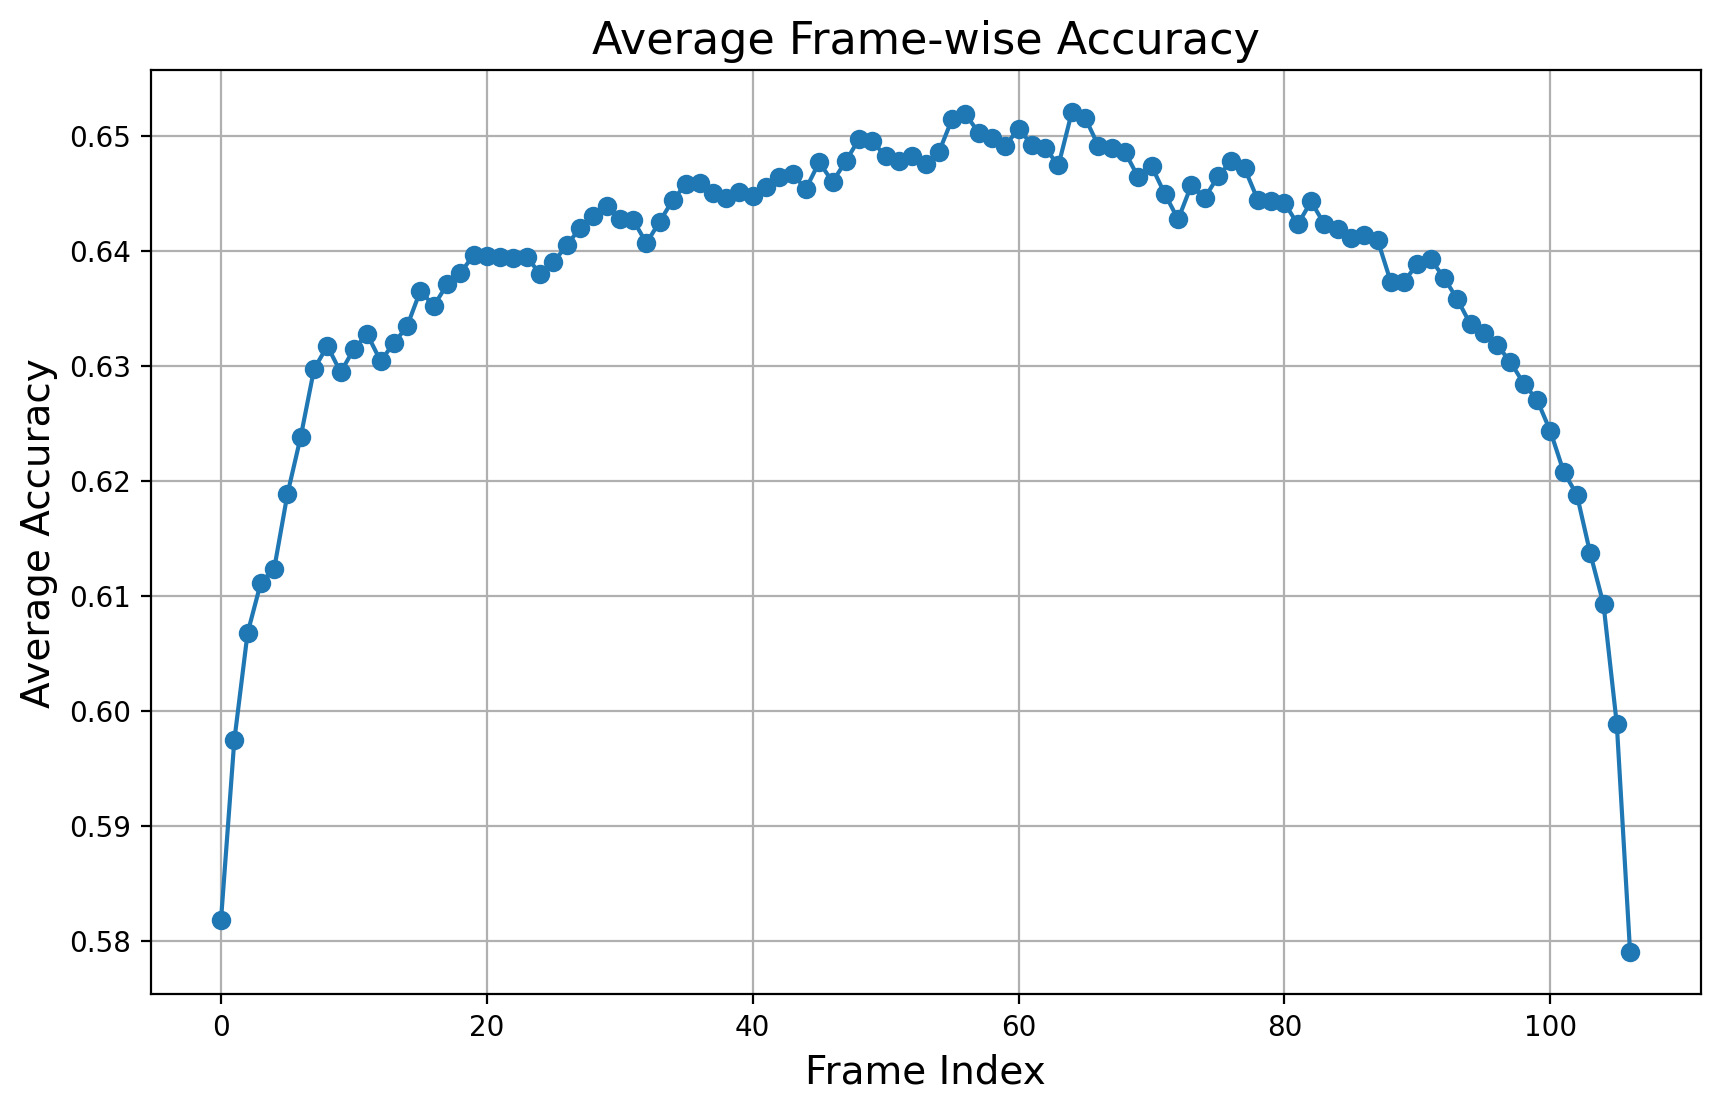

In [18]:
# Compute average accuracy per frame
frame_accuracies = frame_correct_counts / frame_total_counts

# Plot the results
import matplotlib.pyplot as plt

frames = torch.arange(num_frames)
plt.figure(figsize=(10, 6))
plt.plot(frames, frame_accuracies, marker='o')
plt.title("Average Frame-wise Accuracy", fontsize=16)
plt.xlabel("Frame Index", fontsize=14)
plt.ylabel("Average Accuracy", fontsize=14)
plt.grid(True)
plt.show()

# Training run loss Graphs

Text(0.5, 1.0, 'Loss and Accuracy for first-large-vocab')

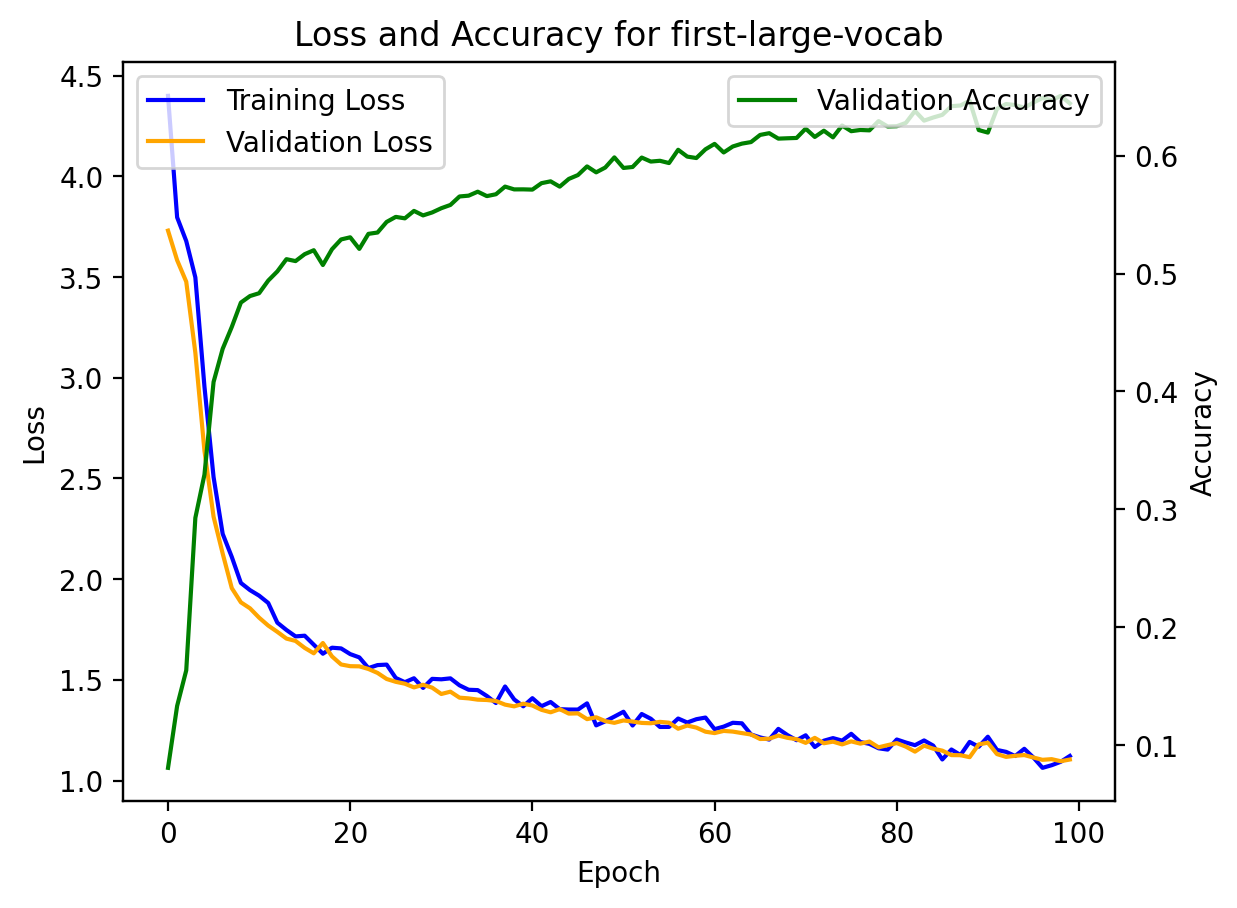

In [19]:
import json

exp = experiment_name
training_history = json.load(open(f'./data/experiments/{exp}/training_history.json'))
train_losses = training_history['train_losses']
val_losses = training_history['val_losses']
val_accuracies = training_history['val_accuracies']
# Plot all 3, with acc having its own y-axis
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(train_losses, label='Training Loss', color='blue')
ax1.plot(val_losses, label='Validation Loss', color='orange')
ax2.plot(val_accuracies, label='Validation Accuracy', color='green')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax2.set_ylabel('Accuracy')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.title(f'Loss and Accuracy for {exp}')